<h1>Cancer Prediction Task</h1>

In [92]:
import pandas as pd

In [93]:
TRAIN_DATA_PATH = r"D:\Universite\Term8\Data Science\Data-Science-Course-spring2025\CA-3\CancerPrediction\train_data.csv"
TEST_DATA_PATH = r"D:\Universite\Term8\Data Science\Data-Science-Course-spring2025\CA-3\CancerPrediction\test_data.csv"
df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26473 entries, 0 to 26472
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  26473 non-null  int64  
 1   Birth_Date          26473 non-null  object 
 2   Weight              26473 non-null  float64
 3   Height              26473 non-null  object 
 4   Urban_Rural         26473 non-null  object 
 5   Occupation          26473 non-null  object 
 6   Insurance_Type      26473 non-null  object 
 7   Family_History      26473 non-null  object 
 8   Cancer_Type         26473 non-null  object 
 9   Stage_at_Diagnosis  26473 non-null  object 
 10  Diagnosis_Date      26473 non-null  object 
 11  Symptoms            25972 non-null  object 
 12  Tumor_Size          26473 non-null  float64
 13  Surgery_Date        18898 non-null  object 
 14  Chemotherapy_Drugs  22423 non-null  object 
 15  Radiation_Sessions  26473 non-null  int64  
 16  Immu

,id,Birth_Date,Weight,Height,Urban_Rural,Occupation,Insurance_Type,Family_History,Cancer_Type,Stage_at_Diagnosis,...,Tumor_Size,Surgery_Date,Chemotherapy_Drugs,Radiation_Sessions,Immunotherapy,Targeted_Therapy,Recurrence_Status,Smoking_History,Alcohol_Use,label
0,1,1994-07-01,64.9,155.0cm,Urban,Unemployed,UEBMI,No,Breast,II,...,8.0,2024-10-19,"Paclitaxel,Docetaxel,Doxorubicin",16,No,Yes,NO,Never,Regular,1
1,2,1992-07-16,61.4,171.0cm,Urban,Factory Worker,UEBMI,Yes,Breast,I,...,10.0,2021-02-28,"Cyclophosphamide,Paclitaxel,Doxorubicin,Docetaxel",10,No,No,Yes,Former,Regular,1
2,3,1948-06-23,60.7,170.0cm,Rural,Unemployed,NRCMS,No,Stomach,IV,...,13.0,2022-09-25,"Fluorouracil,Cisplatin",21,Yes,No,NO,Former,Never,0
3,4,1954-11-26,70.2,171.0cm,Urban,Farmer,URBMI,Yes,Cervical,IV,...,3.0,2024-09-13,Cisplatin,10,No,Yes,NO,Never,Regular,1
4,5,1979-07-08,100.3,186.0cm,Rural,Office Worker,Self-pay,Yes,Lung,II,...,12.0,2023-12-08,"Gemcitabine,Carboplatin",6,Yes,No,Yes,Former,Never,0


Some Preparations Required, like some Type Conversions

In [94]:
def preprocess_data(df):
    df['Height'] = df['Height'].str.extract('(\d+\.?\d*)')[0].astype('float64')
    df['Birth_Date'] = pd.to_datetime(df['Birth_Date'])
    df['Diagnosis_Date'] = pd.to_datetime(df['Diagnosis_Date'])
    df['Surgery_Date'] = pd.to_datetime(df['Surgery_Date'])

    df['Age_at_Diagnosis'] = ((df['Diagnosis_Date'] - df['Birth_Date']).dt.days / 365.25).round()

    df['Days_to_Surgery'] = (df['Surgery_Date'] - df['Diagnosis_Date']).dt.days
    binary_cols = ['Recurrence_Status', 'Targeted_Therapy', 'Immunotherapy', 'Family_History']
    
    for col in binary_cols:
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'NO':0})
        
    stage_mapping = {"I": 1, "II": 2, "III": 3, "IV": 4}
    df['Stage_Encoded'] = df['Stage_at_Diagnosis'].map(stage_mapping)
    
    smoking_mapping = {"Never": 0, "Former": 1, "Current": 2}
    df['Smoking_Encoded'] = df['Smoking_History'].map(smoking_mapping)
    
    alcohol_mapping = {"Never" : 0, "Occasional" : 1, "Regular" : 2}
    df['Alcohol_Use_Encoded'] = df['Alcohol_Use'].map(alcohol_mapping)
    df['Symptoms'].fillna('Unknown', inplace = True)
    df['Chemotherapy_Drugs'].fillna('None', inplace = True)
    median = df['Days_to_Surgery'].median()
    df['Days_to_Surgery'].fillna(value = median, inplace = True)
    df['Chemo_Radiation'] = ((df['Chemotherapy_Drugs'] != 'None') & (df['Radiation_Sessions'] 
                 > 0)).astype(int)

    df['Symptom_Count'] = df['Symptoms'].str.split(',').apply(lambda x: len(x) if 
                    isinstance(x, list) else 0)
    df['BMI'] = (df['Weight'] / ((df['Height'] / 100) ** 2)).round()
    import numpy as np
    df['Surgery_Delay_Category'] = pd.cut(df['Days_to_Surgery'], 
                                        bins = [0, 30, 90, 365, np.inf],
                                    labels = ['Immidiate', 'Short', 'Medium', 'Long'])
    df = df.drop(['Weight', 'Height', 'Days_to_Surgery'], axis=1)
    df = df.drop(['Birth_Date', 'Diagnosis_Date', 'Surgery_Date', 'Stage_at_Diagnosis',
             'Smoking_History', 'Alcohol_Use'], axis = 1)

    return df


In [95]:
train_df = preprocess_data(df)
test_df = preprocess_data(test_df)

Convertion of Yes/ No to binary values with yes corresponding to 1, and no corresponding to 0

Encode Some Columns (one-hot-encoding)

In [96]:
train_df.head()

,id,Urban_Rural,Occupation,Insurance_Type,Family_History,Cancer_Type,Symptoms,Tumor_Size,Chemotherapy_Drugs,Radiation_Sessions,...,Recurrence_Status,label,Age_at_Diagnosis,Stage_Encoded,Smoking_Encoded,Alcohol_Use_Encoded,Chemo_Radiation,Symptom_Count,BMI,Surgery_Delay_Category
0,1,Urban,Unemployed,UEBMI,0,Breast,"Cough, Weight Loss",8.0,"Paclitaxel,Docetaxel,Doxorubicin",16,...,0,1,26.0,2,0,2,1,2,27.0,Long
1,2,Urban,Factory Worker,UEBMI,1,Breast,Blood in Stool,10.0,"Cyclophosphamide,Paclitaxel,Doxorubicin,Docetaxel",10,...,1,1,22.0,1,1,2,1,1,21.0,Long
2,3,Rural,Unemployed,NRCMS,0,Stomach,"Nausea, Vomiting",13.0,"Fluorouracil,Cisplatin",21,...,0,0,66.0,4,1,0,1,2,21.0,Long
3,4,Urban,Farmer,URBMI,1,Cervical,"Nausea, Vomiting",3.0,Cisplatin,10,...,0,1,66.0,4,0,2,1,2,24.0,Long
4,5,Rural,Office Worker,Self-pay,1,Lung,"Cough, Weight Loss",12.0,"Gemcitabine,Carboplatin",6,...,1,0,40.0,2,1,0,1,2,29.0,Long


In [97]:
train_df.isnull().any()


id                        False
Urban_Rural               False
Occupation                False
Insurance_Type            False
Family_History            False
Cancer_Type               False
Symptoms                  False
Tumor_Size                False
Chemotherapy_Drugs        False
Radiation_Sessions        False
Immunotherapy             False
Targeted_Therapy          False
Recurrence_Status         False
label                     False
Age_at_Diagnosis          False
Stage_Encoded             False
Smoking_Encoded           False
Alcohol_Use_Encoded       False
Chemo_Radiation           False
Symptom_Count             False
BMI                       False
Surgery_Delay_Category     True
dtype: bool

In [98]:
train_df.head()

,id,Urban_Rural,Occupation,Insurance_Type,Family_History,Cancer_Type,Symptoms,Tumor_Size,Chemotherapy_Drugs,Radiation_Sessions,...,Recurrence_Status,label,Age_at_Diagnosis,Stage_Encoded,Smoking_Encoded,Alcohol_Use_Encoded,Chemo_Radiation,Symptom_Count,BMI,Surgery_Delay_Category
0,1,Urban,Unemployed,UEBMI,0,Breast,"Cough, Weight Loss",8.0,"Paclitaxel,Docetaxel,Doxorubicin",16,...,0,1,26.0,2,0,2,1,2,27.0,Long
1,2,Urban,Factory Worker,UEBMI,1,Breast,Blood in Stool,10.0,"Cyclophosphamide,Paclitaxel,Doxorubicin,Docetaxel",10,...,1,1,22.0,1,1,2,1,1,21.0,Long
2,3,Rural,Unemployed,NRCMS,0,Stomach,"Nausea, Vomiting",13.0,"Fluorouracil,Cisplatin",21,...,0,0,66.0,4,1,0,1,2,21.0,Long
3,4,Urban,Farmer,URBMI,1,Cervical,"Nausea, Vomiting",3.0,Cisplatin,10,...,0,1,66.0,4,0,2,1,2,24.0,Long
4,5,Rural,Office Worker,Self-pay,1,Lung,"Cough, Weight Loss",12.0,"Gemcitabine,Carboplatin",6,...,1,0,40.0,2,1,0,1,2,29.0,Long


In [99]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26473 entries, 0 to 26472
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   id                      26473 non-null  int64   
 1   Urban_Rural             26473 non-null  object  
 2   Occupation              26473 non-null  object  
 3   Insurance_Type          26473 non-null  object  
 4   Family_History          26473 non-null  int64   
 5   Cancer_Type             26473 non-null  object  
 6   Symptoms                26473 non-null  object  
 7   Tumor_Size              26473 non-null  float64 
 8   Chemotherapy_Drugs      26473 non-null  object  
 9   Radiation_Sessions      26473 non-null  int64   
 10  Immunotherapy           26473 non-null  int64   
 11  Targeted_Therapy        26473 non-null  int64   
 12  Recurrence_Status       26473 non-null  int64   
 13  label                   26473 non-null  int64   
 14  Age_at_Diagnosis      

In [100]:
train_df.head()

,id,Urban_Rural,Occupation,Insurance_Type,Family_History,Cancer_Type,Symptoms,Tumor_Size,Chemotherapy_Drugs,Radiation_Sessions,...,Recurrence_Status,label,Age_at_Diagnosis,Stage_Encoded,Smoking_Encoded,Alcohol_Use_Encoded,Chemo_Radiation,Symptom_Count,BMI,Surgery_Delay_Category
0,1,Urban,Unemployed,UEBMI,0,Breast,"Cough, Weight Loss",8.0,"Paclitaxel,Docetaxel,Doxorubicin",16,...,0,1,26.0,2,0,2,1,2,27.0,Long
1,2,Urban,Factory Worker,UEBMI,1,Breast,Blood in Stool,10.0,"Cyclophosphamide,Paclitaxel,Doxorubicin,Docetaxel",10,...,1,1,22.0,1,1,2,1,1,21.0,Long
2,3,Rural,Unemployed,NRCMS,0,Stomach,"Nausea, Vomiting",13.0,"Fluorouracil,Cisplatin",21,...,0,0,66.0,4,1,0,1,2,21.0,Long
3,4,Urban,Farmer,URBMI,1,Cervical,"Nausea, Vomiting",3.0,Cisplatin,10,...,0,1,66.0,4,0,2,1,2,24.0,Long
4,5,Rural,Office Worker,Self-pay,1,Lung,"Cough, Weight Loss",12.0,"Gemcitabine,Carboplatin",6,...,1,0,40.0,2,1,0,1,2,29.0,Long


<h2>1. Data Exploration and Understanding</h2>

**1.1. Cross Tabulation for Some Features, both row_wise and col_wise**

In [101]:
def cross_tab(df, col1, col2, normalize_option):
    ct = pd.crosstab(df[col1], df[col2])
    ct_pct = pd.crosstab(df[col1], df[col2], normalize = normalize_option) # column-wise
    return ct_pct

features = ['Urban_Rural', 'Family_History', 'Stage_Encoded', 'Immunotherapy',
            'Targeted_Therapy', 'Recurrence_Status', 'Smoking_Encoded', 'Alcohol_Use_Encoded']

for feature in features:
    ct = cross_tab(train_df, feature, 'label', 'index') # row-wise
    print(ct)
    print("\n")

label               0         1
Urban_Rural                    
Rural        0.512554  0.487446
Urban        0.515724  0.484276


label                  0         1
Family_History                    
0               0.514575  0.485425
1               0.513835  0.486165


label                 0         1
Stage_Encoded                    
1              0.406260  0.593740
2              0.406431  0.593569
3              0.591180  0.408820
4              0.657037  0.342963


label                 0         1
Immunotherapy                    
0              0.517548  0.482452
1              0.510395  0.489605


label                    0         1
Targeted_Therapy                    
0                 0.517494  0.482506
1                 0.509837  0.490163


label                     0         1
Recurrence_Status                    
0                  0.489317  0.510683
1                  0.538200  0.461800


label                   0         1
Smoking_Encoded                    
0       

In [102]:
for feature in features:
    ct = cross_tab(train_df, feature, 'label', 'columns') # col-wise
    print(ct)
    print("\n")

label               0         1
Urban_Rural                    
Rural        0.460335  0.463489
Urban        0.539665  0.536511


label                  0         1
Family_History                    
0               0.574409  0.573684
1               0.425591  0.426316


label                 0         1
Stage_Encoded                    
1              0.183047  0.283226
2              0.211694  0.327319
3              0.306229  0.224201
4              0.299030  0.165254


label                 0         1
Immunotherapy                    
0              0.543778  0.536667
1              0.456222  0.463333


label                   0         1
Targeted_Therapy                   
0                 0.58124  0.573762
1                 0.41876  0.426238


label                     0         1
Recurrence_Status                    
0                  0.465991  0.514892
1                  0.534009  0.485108


label                   0         1
Smoking_Encoded                    
0           

**1.2. Numerical Features Analysis**

In [103]:
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
def numerical_feature_analysis(df, feature):
    print(f"Feature: {feature}")
    print(f"Mean: {df[feature].mean()}")
    print(f"Median: {df[feature].median()}")
    print(f"Standard Deviation: {df[feature].std()}")
    print(f"Variance: {df[feature].var()}")
    print(f"Minimum: {df[feature].min()}")
    print(f"Maximum: {df[feature].max()}")
    print("\n")
    
    sns.countplot(x = feature, data = df, hue = 'label')
    plt.title(f"Countplot of {feature} by label")
    plt.show()
    
    alive = df[df['label'] == 1][feature]
    deceased = df[df['label'] == 0][feature]
    t_stat, p_val = stats.ttest_ind(alive, deceased, nan_policy='omit')
    print(f"{feature}: t-stat={t_stat:.2f}, p-value={p_val:.10f}")

Feature: Radiation_Sessions
Mean: 11.991840743398935
Median: 12.0
Standard Deviation: 7.736559030547328
Variance: 59.85434563314341
Minimum: 0
Maximum: 29




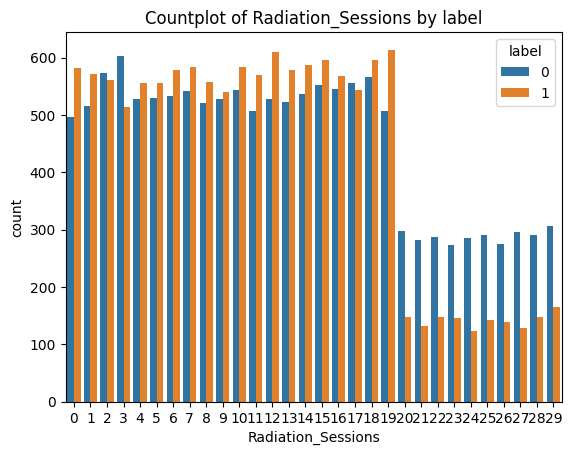

Radiation_Sessions: t-stat=-15.16, p-value=0.0000000000


Feature: Tumor_Size
Mean: 7.737438144524609
Median: 8.0
Standard Deviation: 4.1610649488530385
Variance: 17.31446150857334
Minimum: 0.5
Maximum: 15.0




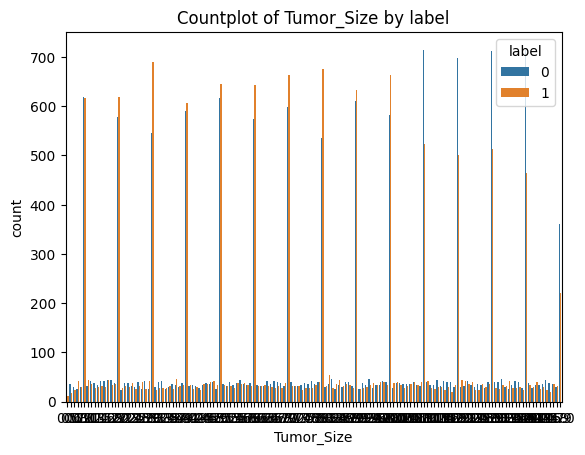

Tumor_Size: t-stat=-9.37, p-value=0.0000000000




In [104]:
numerical_features = ['Radiation_Sessions', 'Tumor_Size']
for col in numerical_features:
    numerical_feature_analysis(train_df, col) 
    print("\n")

Features that are highly correlated: Tumor Size and Radiation_Sessions

**Further Feature Engineering**

Because Weight and Height are highly correlated, I will make a BMI metric out of it

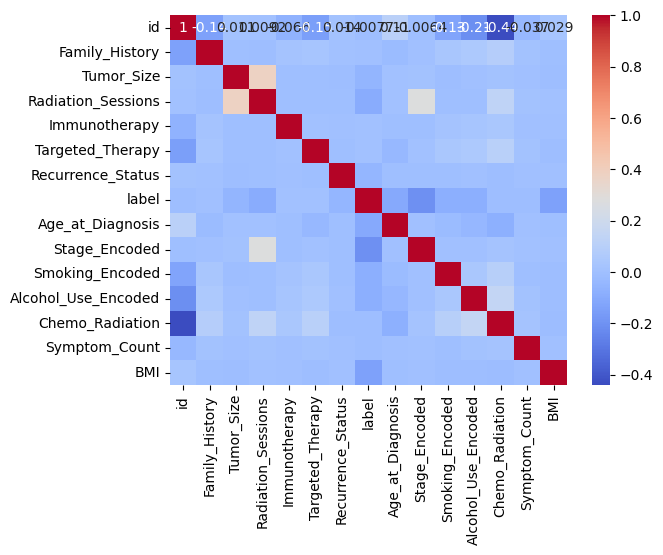

In [ ]:
corr_matrix = train_df.select_dtypes(include=['number']).corr()
threshhold = 0.05
  
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

label_corr = corr_matrix['label'].abs()  # Absolute correlation values
low_corr_features = label_corr[label_corr < threshhold].index.tolist()

# Drop low-correlation features from DataFrame
train_df = train_df.drop(columns=low_corr_features)
low_corr_features = low_corr_features[1:]
test_df = test_df.drop(columns=low_corr_features) 

In [106]:
low_corr_features

['Family_History',
 'Tumor_Size',
 'Radiation_Sessions',
 'Immunotherapy',
 'Targeted_Therapy',
 'Recurrence_Status',
 'Smoking_Encoded',
 'Alcohol_Use_Encoded',
 'Chemo_Radiation',
 'Symptom_Count']

<h2>Different Models</h2>

<h3>SVM</h3>

In [107]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [108]:
X_train = train_df.drop('label', axis = 1)
y_train = train_df['label']

X_test = test_df
# y_test = test_df['label']

In [109]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26473 entries, 0 to 26472
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Urban_Rural             26473 non-null  object  
 1   Occupation              26473 non-null  object  
 2   Insurance_Type          26473 non-null  object  
 3   Cancer_Type             26473 non-null  object  
 4   Symptoms                26473 non-null  object  
 5   Chemotherapy_Drugs      26473 non-null  object  
 6   label                   26473 non-null  int64   
 7   Age_at_Diagnosis        26473 non-null  float64 
 8   Stage_Encoded           26473 non-null  int64   
 9   BMI                     26473 non-null  float64 
 10  Surgery_Delay_Category  21787 non-null  category
dtypes: category(1), float64(2), int64(2), object(6)
memory usage: 2.0+ MB


In [ ]:
numeric_features = ['Tumor_Size', 'Radiation_Sessions',
        'Age_at_Diagnosis', 'BMI']
for col in numeric_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
categorical_features = ['Urban_Rural', 'Occupation', 'Insurance_Type',
           'Symptoms', 'Chemotherapy_Drugs', 'Cancer_Type', 'Surgery_Delay_Category'             
]
encoded_features = ['Stage_Encoded',
                    'Smoking_Encoded',
                    'Alcohol_Use_Encoded']

In [ ]:
# numeric_features = [
#         'Age_at_Diagnosis', 'BMI']
# for col in numeric_features:
#     df[col] = pd.to_numeric(df[col], errors='coerce')
    
# categorical_features = ['Urban_Rural', 'Occupation', 'Insurance_Type',
#            'Symptoms', 'Chemotherapy_Drugs', 'Cancer_Type', 'Surgery_Delay_Category'             
# ]
# encoded_features = ['Stage_Encoded']

In [112]:
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder = 'passthrough'
)


<h3>Experiment with Best Model Prediction</h3>

In [113]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import joblib

# 1. Define all model pipelines
models = {
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(random_state=42))
    ]),
    'LightGBM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(random_state=42))
    ]),
    'CatBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', CatBoostClassifier(random_state=42, verbose=0))
    ])
}

# 2. Define parameter grids for each model
param_grids = {
    'XGBoost': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__subsample': [0.6, 0.8],
        'classifier__colsample_bytree': [0.6, 0.8]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__subsample': [0.6, 0.8],
        'classifier__colsample_bytree': [0.6, 0.8]
    },
    'CatBoost': {
        'classifier__iterations': [100, 200],
        'classifier__depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__l2_leaf_reg': [1, 3]
    }
}

# 3. Create validation set from training data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# 4. Train and evaluate all models
best_models = {}
best_scores = {}

for name in models.keys():
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(
        models[name],
        param_grids[name],
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    
    # Get best model and score
    best_models[name] = grid_search.best_estimator_
    val_score = accuracy_score(y_val, best_models[name].predict(X_val))
    best_scores[name] = val_score
    print(f"{name} best validation accuracy: {val_score:.4f}")
    
    # Save model
    joblib.dump(best_models[name], f'{name}_best_model.pkl')

# 5. Select best model
best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]
print(f"\nBest model: {best_model_name} with accuracy {best_scores[best_model_name]:.4f}")

# 6. Retrain best model on full training data
best_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# 7. Make predictions and save
y_pred = best_model.predict(X_test)
result = pd.DataFrame({'id': test_df['id'], 'label': y_pred})
RESULT_PATH = r"D:\Universite\Term8\Data Science\Data-Science-Course-spring2025\CA-3\CancerPrediction\result.csv"

result.to_csv(RESULT_PATH, index=False)
print(f"Predictions saved to {RESULT_PATH} using {best_model_name}")


Training XGBoost...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
XGBoost best validation accuracy: 0.7715

Training LightGBM...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 10273, number of negative: 10905
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 485
[LightGBM] [Info] Number of data points in the train set: 21178, number of used features: 181
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485079 -> initscore=-0.059702
[LightGBM] [Info] Start trai